In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np

In [2]:
import logging
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

logging.basicConfig(level=os.getenv('LOG_LEVEL', 'ERROR'))

logger = logging.getLogger(__name__)

class RRRLoss(nn.Module):
    def __init__(self, lambda1=1000.0):
        """
        Right for the Right Reasons loss function.

        Bibtex:
            @article{ross2017RRR,
              title={Right for the right reasons: Training differentiable models by constraining their explanations},
              author={Ross, Andrew Slavin and Hughes, Michael C and Doshi-Velez, Finale},
              journal={arXiv preprint arXiv:1703.03717},
              year={2017}
            }

        Args:
            lambda1: Weight for the explanation (input gradient) loss term
        """
        super().__init__()
        self.lambda1 = lambda1
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, logits, targets, inputs, masks):
        """
        Compute the RRR loss.

        Args:
            logits: Model output logits (B x num_classes)
            targets: Ground truth labels (B)
            model: The model being trained
            inputs: Input data (B x ...)
            masks: Binary masks indicating where gradients should be small (B x ...)

        Returns:
            total_loss: Combined loss value
            losses: Dictionary containing individual loss components
        """
        ce_loss = self.cross_entropy(logits, targets)
        # boolean mask to select indices for which there is a mask available
        # this little optimisation ensures that we do not use autograd on inputs that will
        # be ignored anyway
        log_probs = F.softmax(logits, dim=1)
        summed_log_probs = log_probs.sum()
        gradients = torch.autograd.grad(summed_log_probs, inputs, create_graph=True, retain_graph=True)[0]
        gradient_loss = (masks * gradients).pow(2).mean()
        gradient_loss_item = gradient_loss.item()

        total_loss = ce_loss + self.lambda1 * gradient_loss

        losses = {
            'total_loss': total_loss.item(),
            'ce_loss': ce_loss.item(),
            'gradient_loss': gradient_loss_item
        }

        return total_loss, losses


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms
transform = transforms.Compose([
    transforms.Resize(32),  # ResNet expects 32x32 images
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         transform=transform,
                                         download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model
model = resnet18(pretrained=False)
# Modify first layer to accept single channel
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Modify final layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/youritomassen/Projects/Uni/Master Thesis/diveslowlearnfast/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/youritomassen/Projects/Uni/Master Thesis/diveslowlearnfast/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

Epoch [1/1], Step [100/938], Loss: 0.3198
Epoch [1/1], Step [200/938], Loss: 0.1672
Epoch [1/1], Step [300/938], Loss: 0.1292
Epoch [1/1], Step [400/938], Loss: 0.1161
Epoch [1/1], Step [500/938], Loss: 0.1036
Epoch [1/1], Step [600/938], Loss: 0.0853
Epoch [1/1], Step [700/938], Loss: 0.0894
Epoch [1/1], Step [800/938], Loss: 0.0777
Epoch [1/1], Step [900/938], Loss: 0.0812


In [5]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 98.60%


In [4]:
def compute_gradient(xb, logits, yb):
    log_probs = F.softmax(logits, dim=1)
    loss = F.cross_entropy(log_probs, yb)
    gradients = torch.autograd.grad(loss, xb, create_graph=True, retain_graph=True)[0]
    return gradients


def create_mask(xb):
    """
    Creates a mask that has 1/4th of the pixels in the top right corner of the image set
    to 1
    """
    mask = torch.zeros_like(xb)
    _, _, H, W = xb.shape
    size = H // 4
    mask[:, :, 0:size, 0:size] = 1
    return mask

In [5]:
xb, yb = next(iter(test_loader))
xb.requires_grad = True
outputs = model(xb)
gradients = compute_gradient(xb, outputs, yb).squeeze(1).detach().numpy()
gradients.shape

(64, 32, 32)

In [6]:
masks = create_mask(xb)

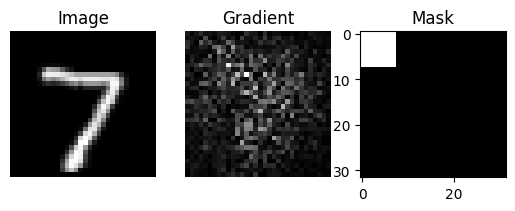

In [7]:
idx = 0

ax = plt.subplot(131)
ax.imshow(xb[idx].squeeze(0).detach().numpy(), cmap='gray')
ax.axis('off')
ax.set_title('Image')

ax = plt.subplot(132)
ax.imshow(np.abs(gradients[idx]), cmap='gray')
ax.axis('off')
ax.set_title('Gradient')

ax = plt.subplot(133)
ax.imshow(masks[idx].squeeze(0).detach().numpy(), cmap='gray')
ax.set_title('Mask')
plt.show()

In [8]:
model = resnet18(pretrained=False)
# Modify first layer to accept single channel
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Modify final layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Loss function and optimizer
criterion = RRRLoss(lambda1=100_000.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
images, labels = next(iter(train_loader))
images.requires_grad = True
outputs = model(images)
masks = create_mask(images)
masks = ~masks.to(dtype=torch.bool)
loss, losses = criterion(outputs, labels, images, masks)
losses

{'total_loss': 2.506136417388916,
 'ce_loss': 2.506136417388916,
 'gradient_loss': 3.9017555283115905e-18}

In [12]:
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        # Forward pass
        outputs = model(images)
        masks = create_mask(images)
        masks = ~masks.to(dtype=torch.bool)
        loss, _ = criterion(outputs, labels, images, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

Epoch [1/1], Step [100/938], Loss: 0.0763
Epoch [1/1], Step [200/938], Loss: 0.0748
Epoch [1/1], Step [300/938], Loss: 0.0699
Epoch [1/1], Step [400/938], Loss: 0.0716
Epoch [1/1], Step [500/938], Loss: 0.0616
Epoch [1/1], Step [600/938], Loss: 0.0660
Epoch [1/1], Step [700/938], Loss: 0.0616
Epoch [1/1], Step [800/938], Loss: 0.0554
Epoch [1/1], Step [900/938], Loss: 0.0458


In [13]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 98.62%


In [14]:
xb, yb = next(iter(test_loader))
xb.requires_grad = True
outputs = model(xb)
gradients = compute_gradient(xb, outputs, yb).squeeze(1).detach().numpy()
gradients.shape

(64, 32, 32)

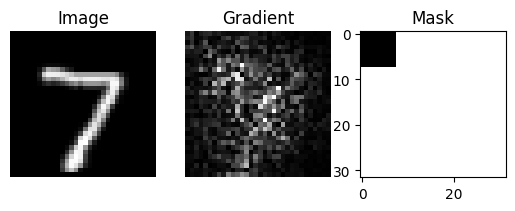

In [15]:
idx = 0

ax = plt.subplot(131)
ax.imshow(xb[idx].squeeze(0).detach().numpy(), cmap='gray')
ax.axis('off')
ax.set_title('Image')

ax = plt.subplot(132)
ax.imshow(np.abs(gradients[idx]), cmap='gray')
ax.axis('off')
ax.set_title('Gradient')

ax = plt.subplot(133)
ax.imshow(masks[idx].to(dtype=torch.bool).squeeze(0).detach().numpy(), cmap='gray')
ax.set_title('Mask')
plt.show()